In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df  = pd.read_csv("../input/real_test.csv")
train_x = train_df.iloc[:, 2:].values
test_x = test_df.iloc[:, 1:].values
train_y = train_df.target.values

In [3]:
y_train = train_df.target.values

In [4]:
train_test_x_org = np.concatenate([train_x, test_x], axis=0)

In [5]:
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
            22,24,25,26,27,41,29,
            32,35,37,40,48,49,47,
            55,51,52,53,60,61,62,103,65,66,67,69,
            70,71,74,78,79,
            82,84,89,90,91,94,95,96,97,99,
            105,106,110,111,112,118,119,125,128,
            130,133,134,135,137,138,
            140,144,145,147,151,155,157,159,
            161,162,163,164,167,168,
            170,171,173,175,176,179,
            180,181,184,185,187,189,
            190,191,195,196,199]
for j in reverse_list:
    train_test_x_org[:, j] *= -1

In [6]:
# scaling
scaler = StandardScaler()
train_test_x = scaler.fit_transform(train_test_x_org)

In [7]:
train_test_x_cnt = np.zeros((train_test_x.shape[0], 800))

for j in range(200):
    for i in range(1, 4):
        x = np.round(train_test_x[:, j], i+1)
        dic = pd.value_counts(x).to_dict()
        train_test_x_cnt[:, i+j*4] = pd.Series(x).map(dic)
    x = train_test_x[:, j]
    dic = pd.value_counts(x).to_dict()
    train_test_x_cnt[:, j*4] = pd.Series(x).map(dic)
    
train_test_x2 = np.zeros((train_test_x.shape[0], 1000))
for j in range(200):
    train_test_x2[:, 5*j+1:5*j+5] = train_test_x_cnt[:, 4*j:4*j+4]
    train_test_x2[:, 5*j] = train_test_x[:, j]

In [13]:
params = {
    'bagging_freq': 5,
    'bagging_fraction': 1.0,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.005,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 30,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 64,
    'num_threads': 32,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1}

In [11]:
tratest_X = np.concatenate([
    np.concatenate([
        train_test_x2[:200000, 5*cnum:5*cnum+5], 
        np.ones((y_train.shape[0], 1)).astype("int")*cnum
    ], axis=1) for cnum in range(200)], axis=0
)
tratest_y = np.concatenate([y_train for cnum in range(200)], axis=0)
tratest_dset = lgb.Dataset(
    tratest_X, tratest_y, 
    feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
    categorical_feature=['varnum'], free_raw_data=False)

In [22]:
nfold = 5

In [19]:
lgb.cv(params, tratest_dset, early_stopping_rounds=200, nfold=nfold, num_boost_round=10000, verbose_eval=100)

[100]	cv_agg's binary_logloss: 0.484684 + 3.56466e-06
[200]	cv_agg's binary_logloss: 0.395443 + 1.67381e-05
[300]	cv_agg's binary_logloss: 0.355431 + 9.95469e-06
[400]	cv_agg's binary_logloss: 0.337765 + 7.15578e-06
[500]	cv_agg's binary_logloss: 0.330231 + 8.90267e-06
[600]	cv_agg's binary_logloss: 0.327138 + 1.11591e-05
[700]	cv_agg's binary_logloss: 0.32591 + 1.27802e-05
[800]	cv_agg's binary_logloss: 0.325433 + 1.34071e-05
[900]	cv_agg's binary_logloss: 0.325252 + 1.38142e-05
[1000]	cv_agg's binary_logloss: 0.325183 + 1.40459e-05
[1100]	cv_agg's binary_logloss: 0.325158 + 1.4167e-05
[1200]	cv_agg's binary_logloss: 0.325149 + 1.42657e-05
[1300]	cv_agg's binary_logloss: 0.325145 + 1.43004e-05
[1400]	cv_agg's binary_logloss: 0.325145 + 1.43507e-05
[1500]	cv_agg's binary_logloss: 0.325144 + 1.44303e-05
[1600]	cv_agg's binary_logloss: 0.325145 + 1.45939e-05


{'binary_logloss-mean': [0.6899598825266284,
  0.6868043265947537,
  0.6836800965777656,
  0.6805867869014405,
  0.6775239953514156,
  0.6744913255910185,
  0.6714883985012008,
  0.6685148250862787,
  0.665570238321543,
  0.6626542711686645,
  0.6597665625910911,
  0.6569067605739681,
  0.6540745134541457,
  0.651269482522197,
  0.6484913332278814,
  0.6457397340155142,
  0.6430143589828501,
  0.6403148928145024,
  0.6376410192355056,
  0.6349924304606817,
  0.6323688229823873,
  0.6297698986783345,
  0.6271953640602478,
  0.6246449306287797,
  0.62211831372113,
  0.6196152341251866,
  0.6171354167066071,
  0.6146785905294825,
  0.6122444902092615,
  0.6098328529081352,
  0.6074434207249579,
  0.6050759402206669,
  0.6027301605931706,
  0.6004058338839467,
  0.5981027213868104,
  0.5958205834721384,
  0.5935591814914514,
  0.5913182892825967,
  0.5890976746559851,
  0.5868971154978377,
  0.5847163882469413,
  0.5825552744370525,
  0.5804135643739794,
  0.5782910416832442,
  0.576187494

In [23]:
skf = StratifiedKFold(n_splits=nfold)
skf.get_n_splits(train_test_x2[:200000, :], train_y)

5

In [21]:
train_idx_list = []
valid_idx_list = []
for train_index, test_index in skf.split(train_test_x2[:200000, :], train_y):
    train_idx_list.append(train_index)
    valid_idx_list.append(test_index)

In [26]:
clf_list = []
oof_pred = np.zeros((200000, 200))
tes_pred = np.zeros((100000, 200, nfold))

for i in range(nfold):
    
    trn_idx = train_idx_list[i]
    val_idx = valid_idx_list[i]

    tra_X = np.concatenate([
        np.concatenate([
            train_test_x2[trn_idx, 5*cnum:5*cnum+5], 
            np.ones((trn_idx.shape[0], 1)).astype("int")*cnum
        ], axis=1) for cnum in range(200)], axis=0
    )
    tra_y = np.concatenate([y_train[trn_idx] for cnum in range(200)], axis=0)

    val_X = np.concatenate([
        np.concatenate([
            train_test_x2[val_idx, 5*cnum:5*cnum+5], 
            np.ones((val_idx.shape[0], 1)).astype("int")*cnum
        ], axis=1) for cnum in range(200)], axis=0
    )
    tes_X = np.concatenate([
        np.concatenate([
            train_test_x2[200000:, 5*cnum:5*cnum+5], 
            np.ones((100000, 1)).astype("int")*cnum
        ], axis=1) for cnum in range(200)], axis=0
    )
    
    train_dset = lgb.Dataset(
        tra_X, tra_y, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )
    clf = lgb.train(params, train_set=train_dset, num_boost_round=1500, verbose_eval=100)
    l = val_idx.shape[0]
    
    pred_valid = clf.predict(val_X)
    pred_tes = clf.predict(tes_X)
    for j in range(200):
        oof_pred[val_idx, j] = pred_valid[j*l:(j+1)*l]
        tes_pred[:, j, i] = pred_tes[j*100000:(j+1)*100000]
    
    clf_list.append(clf)
    print("i = ", i)

i =  0
i =  1
i =  2
i =  3
i =  4


In [28]:
roc_auc_score(y_train, (9 * oof_pred / (1 - oof_pred)).prod(axis=1))

0.9259151469402911

In [30]:
l = y_train.shape[0]
pred_valid_p = np.ones(l) * 1 / 9
for j in range(200):
    if roc_auc_score(y_train, oof_pred[:, j]) >= 0.500:
        pred_valid_p *= (9 * oof_pred[:, j] / (1 - oof_pred[:, j]))
roc_auc_score(y_train, pred_valid_p)

0.926009984401244

In [31]:
l = y_train.shape[0]
pred_valid_p = np.ones(l) * 1 / 9
for j in range(200):
    if roc_auc_score(y_train, oof_pred[:, j]) >= 0.502:
        pred_valid_p *= (9 * oof_pred[:, j] / (1 - oof_pred[:, j]))
roc_auc_score(y_train, pred_valid_p)

0.9260052973036538

In [29]:
l = y_train.shape[0]
pred_valid_p = np.ones(l) * 1 / 9
for j in range(200):
    if roc_auc_score(y_train, oof_pred[:, j]) >= 0.505:
        pred_valid_p *= (9 * pred_tes[:, j] / (1 - oof_pred[:, j]))
roc_auc_score(y_train, pred_valid_p)

0.9258495867608392

In [36]:
# test

In [35]:
pred_tes_m = tes_pred.mean(axis=2)

In [37]:
pred_test_p = np.ones(100000) * 1 / 9
for j in range(200):
    if roc_auc_score(y_train, oof_pred[:, j]) >= 0.500:
        pred_test_p *= (9 * pred_tes_m[:, j] / (1 - pred_tes_m[:, j]))

(array([54431., 14775.,  7770.,  5019.,  3651.,  2926.,  2349.,  2216.,
         2362.,  4501.]),
 array([1.06519394e-04, 1.00095428e-01, 2.00084337e-01, 3.00073246e-01,
        4.00062155e-01, 5.00051064e-01, 6.00039973e-01, 7.00028882e-01,
        8.00017791e-01, 9.00006700e-01, 9.99995609e-01]),
 <a list of 10 Patch objects>)

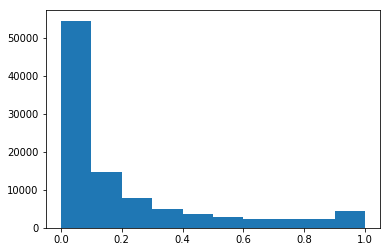

In [39]:
pred_test_pp = pred_test_p / (1 + pred_test_p)
plt.hist(pred_test_pp)

In [40]:
samp = pd.read_csv("../input/sample_submission.csv")
test_df_samp = pd.DataFrame({"ID_code":test_df.ID_code.values , "target":pred_test_pp})
sub_df_ = pd.merge(samp[["ID_code"]], test_df_samp, how="left").fillna(0)

In [41]:
import scipy.stats
# CHECK
compare_df = pd.read_csv("../output/rankave_904_910.csv")
compare_df_read = pd.merge(test_df[["ID_code"]], compare_df)

print(np.corrcoef(compare_df_read.target.values, test_df_samp.target.values))
print(scipy.stats.spearmanr(compare_df_read.target.values, test_df_samp.target.values))

[[1.         0.82509919]
 [0.82509919 1.        ]]
SpearmanrResult(correlation=0.9741994476303213, pvalue=0.0)


In [42]:
sub_df_.to_csv("../output/concat_lgb_hrd_0407_1.csv", index=False)